In [5]:
# pandas to open data files & processing it.
import pandas as pd
# to see all columns
pd.set_option('display.max_columns', None)
# To see whole text
pd.set_option('max_colwidth', -1)

# numpy for numeric data processing
import numpy as np

# keras for deep learning model creation
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.utils import plot_model

# to fix random seeds
import random
import tensorflow as tf
import torch
import os

# Regular Expression for text cleaning
import re

# to track the progress - progress bar
from tqdm.notebook import tqdm

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


Let's open the data files now.

In [6]:
sarcasm_data = pd.read_csv("/kaggle/input/sarcasm/train-balanced-sarcasm.csv")
print(sarcasm_data.shape)
sarcasm_data.head()

(1010826, 10)


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well."
1,0,You do know west teams play against west teams more than east teams right?,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.
2,0,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york nigga"" ones are.",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for that. It was made by our boy EASports_MUT


We just need `comment` & `label` column.<br>
So, let's remove others.

In [7]:
sarcasm_data.drop(['author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment'], axis=1, inplace=True)
# remove empty rows
sarcasm_data.dropna(inplace=True)
sarcasm_data.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams more than east teams right?
2,0,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1"
3,0,"This meme isn't funny none of the ""new york nigga"" ones are."
4,0,I could use one of those tools.


In [8]:
sarcasm_data['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

So, there are `505368` sentences with sarcastic news headlines !!<br>

Let's do some pre-processing on our text data.<br>
These are the common practices which can improve performance in almost any NLP task.<br><br>

One common thing we can do is to remove `contractions`.<br>
### Like, "ain't" to "is not", "can't" to "can not" etc.

In [9]:
mispell_dict = {"ain't": "is not", "cannot": "can not", "aren't": "are not", "can't": "can not", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",
                "doesn't": "does not",
                "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
                "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
                "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would",
                "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
                "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "wont": "will not", "won't've": "will not have", "would've": "would have",
                "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color',
                'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
                'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What',
                'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I',
                'theBest': 'the best', 'howdoes': 'how does', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what',
                'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

mispell_dict = {k.lower(): v.lower() for k, v in mispell_dict.items()}

Let's make our preprocessing function.

In [10]:
def preprocessing_text(s):
    # making our string lowercase & removing extra spaces
    s = str(s).lower().strip()
    
    # remove contractions.
    s = " ".join([mispell_dict[word] if word in mispell_dict.keys() else word for word in s.split()])
    
    # removing \n
    s = re.sub('\n', '', s)
    
    # put spaces before & after punctuations to make words seprate. Like "king?" to "king", "?".
    s = re.sub(r"([?!,+=—&%\'\";:¿।।।|\(\){}\[\]//])", r" \1 ", s)
    
    # Remove more than 2 continues spaces with 1 space.
    s = re.sub('[ ]{2,}', ' ', s).strip()
    
    return s

In [11]:
# apply preprocessing_text function
sarcasm_data['comment'] = sarcasm_data['comment'].apply(preprocessing_text)
sarcasm_data.head()

,label,comment
0,0,nc and nh.
1,0,you do know west teams play against west teams more than east teams right ?
2,0,"they were underdogs earlier today , but since gronk ' s announcement this afternoon , the vegas line has moved to patriots -1"
3,0,"this meme is not funny none of the "" new york nigga "" ones are."
4,0,i could use one of those tools.


In [12]:
# total unique words we are going to use.
TOTAL_WORDS = 40000

# max number of words one sentence can have
MAX_LEN = 50

# width of of 1D embedding vector
EMBEDDING_SIZE = 300

In [13]:
%%time
tokenizer = Tokenizer(num_words=TOTAL_WORDS)
tokenizer.fit_on_texts(list(sarcasm_data['comment']))

train_data = tokenizer.texts_to_sequences(sarcasm_data['comment'])
train_data = pad_sequences(train_data, maxlen = MAX_LEN)
target = sarcasm_data['label']

CPU times: user 39.6 s, sys: 325 ms, total: 39.9 s
Wall time: 39.9 s


Download this tokenizer for using it in preprocessing in google colab

In [14]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

Let's open embedding file now & store in a matrix.

In [15]:
%%time
EMBEDDING_FILE = '/kaggle/input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in tqdm(open(EMBEDDING_FILE)))

word_index = tokenizer.word_index
nb_words = min(TOTAL_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_SIZE))

0it [00:00, ?it/s]

CPU times: user 2min 17s, sys: 8.67 s, total: 2min 26s
Wall time: 2min 41s


In [16]:
for word, i in tqdm(word_index.items()):
    if i >= TOTAL_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

  0%|          | 0/166508 [00:00<?, ?it/s]

Let's build our NLP deep learning model now..

In [17]:
embedding_matrix.shape

(40000, 300)

In [18]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    tf.random.set_seed(seed)

# We fix all the random seed so that, we can reproduce the results.
seed_everything(2020)

In [19]:
input_layer = Input(shape=(MAX_LEN,))

embedding_layer = Embedding(TOTAL_WORDS, EMBEDDING_SIZE, weights = [embedding_matrix])(input_layer)

LSTM_layer = Bidirectional(LSTM(128, return_sequences = True))(embedding_layer)
maxpool_layer = GlobalMaxPool1D()(LSTM_layer)

dense_layer_1 = Dense(64, activation="relu")(maxpool_layer)
dropout_1 = Dropout(0.5)(dense_layer_1)

dense_layer_2 = Dense(32, activation="relu")(dropout_1)
dropout_2 = Dropout(0.5)(dense_layer_2)

output_layer = Dense(1, activation="sigmoid")(dropout_2)

# model = Model(input=input_layer, output=output_layer)
model = Model(inputs=input_layer, outputs=output_layer)


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 300)           12000000  
                                                                 
 bidirectional (Bidirectiona  (None, 50, 256)          439296    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0     

## Before training the model first, let's understand our model first.

`input_layer` : Input layer with which we will get text sentence.<br><br>
`embedding_layer` : Embedding layer with which we will map each word with it's corresponding embedding vector.<br><br>
`LSTM_layer` : LSTM layer with 128 LSTM cells.
* We are using Bidirectional to run LSTM from both side of the text sentence.
    1. Left to Right
    2. Right to Left
* Purpose of this is to give our model both side context.
* It's also possible to not use this. But using this have provided good results.
<br><br>
`maxpool_layer` : Max pool layer is used to minimize the image size by pooling maximum number out of 2x2 grid.
![maxpool](https://distilledai.com/wp-content/uploads/2020/04/2x2-max-pool-CNN.png)
<br><br>
`dense_layer_1` : Feed-forward dense layer to classify the features captured by LSTM layer.
<br><br>
`dropout_1` : Dropout is interesting trick. In Dropout, we randomly turn off some percentage of our neurons so that their's output can't go to next layer. Here we are turning off 20% of our total neurons.
* Purpose of doing this is again to make our training robust.
* Network should not depend some specific neurons to make predictions. And random turn will allow us to do that.
* Picture below help us to understand it. 
![dropout](https://distilledai.com/wp-content/uploads/2020/04/dropout-in-deep-learning.png)
<br><br>
`dense_layer_2` & `dropout_2` are same as above.
<br><br>
`output_layer` : To get the output prediction from the neural network.


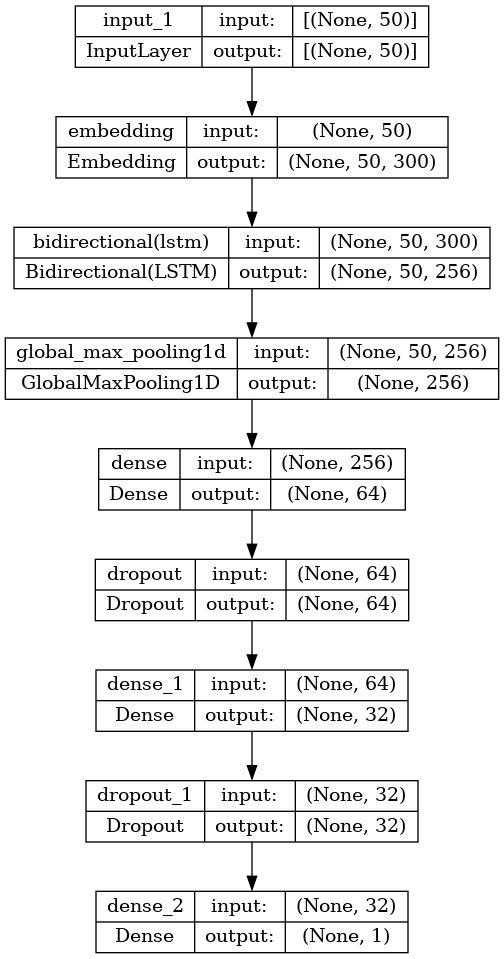

In [20]:
plot_model(model, show_shapes=True)

## Let's start the training of our model

In [ ]:
BATCH_SIZE = 512
EPOCHS = 2

history = model.fit(
    train_data, target,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    # We are using randomly selected 20% sentences as validation data.
    validation_split=0.2
)

Epoch 1/2
1062/1580 [===================>..........] - ETA: 8:13 - loss: 0.5769 - accuracy: 0.7003

Download the model and use it on google colab

In [ ]:
import pickle

# Save the model to disk
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
model.save('model.h5')

### Cool !!

Training is over.<br>
We can see validation accuracy above.<br>

### Let's test our model on some random input now.

In [ ]:
sarcasm_data[sarcasm_data['label']==1].sample(10)

In [ ]:
BATCH_SIZE = 512
loss, accuracy = model.evaluate(train_data, target, batch_size=BATCH_SIZE)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

In [ ]:
sentence = "sun rises from the east"
sentence = preprocessing_text(sentence)
print(sentence)

sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen = MAX_LEN)
sentence

We can see, how our sentence got converted into numbers.<br>

## We are doing padding to keep the final length same for every sentence no matter the sentence length.
## Our Neural network have learned to ignore 0 in the training itself.

In [ ]:
# Make the prediction.
prediction = model.predict(sentence)
prediction[0][0]

In [ ]:
import keras
print(keras.__version__)
print(tf.__version__)

In [ ]:
print("So, it's saying sentence have probability of %.3f percent"%(prediction[0][0]*100))

In [ ]:
sentence = "Isn't it great that, your girlfriend dumped you?"
sentence = preprocessing_text(sentence)
print(sentence)

sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen = MAX_LEN)
sentence

In [ ]:
# Make the prediction.
prediction = model.predict(sentence)
prediction[0][0]

In [ ]:
print("So, it's saying sentence have probability of %.3f percent"%(prediction[0][0]*100))

In [ ]:
sarcasm_data.head(70)